In [1]:
import numpy as np
import pandas as pd
import csv
import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
from point_net import PointNetClassHead
from utils import normalize_point_cloud, find_surface_indices

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import os
import warnings
warnings.filterwarnings("ignore")

In [5]:
BATCH_SIZE = 1
NUM_CLASSES = 1
DEVICE = 'cpu'
print(DEVICE)

cpu


In [6]:
point_clouds_info = pd.read_csv('point_Clouds_info.csv');
dataI = pd.read_csv('dataI_with_stage.csv') ; dataI = dataI.drop('Unnamed: 0', axis = 1)
dataP = pd.read_csv('dataP_with_stage.csv') ; dataP = dataP.drop('Unnamed: 0', axis = 1)
dataTrack = pd.read_csv('dataTrack_with_stage.csv') ; dataTrack = dataTrack.drop('Unnamed: 0', axis = 1)
dataP['subjid'] = dataP['subjid'].astype(str)  # so that we can work with sklearn group split
dataSet  = pd.concat([dataI, dataP, dataTrack])
print(dataSet.shape)
patients = dataSet.loc[dataSet['group'] != 'control']
patients.reset_index(drop=True , inplace = True)
print(patients.shape)

(4407, 308)
(2932, 308)


In [7]:
patients['Disease_Stage'] = patients['Disease_Stage'].apply(lambda x: int(x[6]) if not x.startswith('Error') else np.NaN)
# patients = patients[~np.isnan(patients['Disease_Stage'])] # Drop empty rows (where 'error' was the prefix)
print(patients.shape)
imputer = KNNImputer(n_neighbors=15, weights="uniform")
numeric_columns = patients.select_dtypes(include='number').columns
patients.loc[:,numeric_columns] = pd.DataFrame(imputer.fit_transform(patients[numeric_columns]), columns=numeric_columns)
patients.reset_index(drop=True)
print(patients.shape)
patients['Disease_Stage'] = patients['Disease_Stage'].round(0).astype(int).astype(str)

(2932, 308)
(2932, 308)


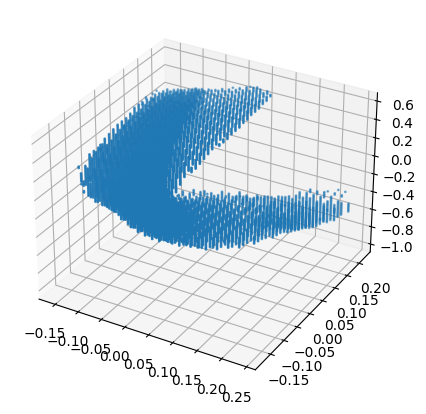

In [8]:
P = pd.read_csv('Point_clouds/960/region4.csv').to_numpy()
P.shape
# Create a 3D scatter plot with custom colors
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P[0], P[1], P[2] , s= 1)

In [9]:
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    x_limits = ax.get_xlim()
    x_vals = np.array(x_limits)
    y_vals = x_vals  * slope + intercept
    ax.set_ylim(x_limits)
    ax.plot(x_vals, y_vals, '--', color='green', alpha=0.8)

### Classes and Methods

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_row = self.data.iloc[idx]
        disease_stage = subject_row['Disease_Stage']
        target = subject_row['PIN']
        path = subject_row['identifier']
        age = subject_row['ageAtscan']
        subjid = subject_row['subjid']
        
        point_clouds_row = point_clouds_info.loc[point_clouds_info['identifier'] == path]
        
        index = int(point_clouds_row['index'])
        
        n = int(point_clouds_row[f'n_{REGION_LABEL}'])
        P = pd.read_csv(f'Point_clouds/{index}/region{REGION_LABEL}.csv').to_numpy()

        if NUM_POINTS < n:
            sampled_surface_indices = np.random.choice(n, size=NUM_POINTS, replace=False)
        else:
            sampled_surface_indices = np.random.choice(n, size=NUM_POINTS, replace=True)
        P = P[:,sampled_surface_indices]
        
        return torch.Tensor(P), torch.tensor(target, dtype = torch.float), disease_stage , path , age , subjid

In [11]:
skf_gen = StratifiedGroupKFold(n_splits=6, shuffle=False).split(patients, y=patients['Disease_Stage'] , groups= patients['subjid'])
train_ind , not_train_ind = next(iter(skf_gen))
X_train = patients.iloc[train_ind] 
X_not_train = patients.iloc[not_train_ind]

skf_gen = StratifiedGroupKFold(n_splits=2, shuffle=False).split(X_not_train, y=X_not_train['Disease_Stage'] , groups= X_not_train['subjid'])
test_ind , valid_ind = next(iter(skf_gen))
X_test = X_not_train.iloc[test_ind] 
X_valid = X_not_train.iloc[valid_ind]

# print(X_test['subjid'].unique())
X_test = X_test[X_test['subjid'] == '214181']

print(patients.shape)
print(X_train.shape , X_not_train.shape , X_test.shape , X_valid.shape)

train_dataset = CustomDataset(X_train)
valid_dataset = CustomDataset(X_valid)
test_dataset = CustomDataset(X_test)
not_train_dataset = CustomDataset(X_not_train)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
not_train_loader = DataLoader(not_train_dataset, batch_size=BATCH_SIZE, shuffle=False)

(2932, 308)
(2443, 308) (489, 308) (4, 308) (245, 308)


## Region 4

Processing test data:   0%|          | 0/4 [00:00<?, ?it/s]

Actual:  [1.3630719184875488, 'Predicted:', [[2.1952433586120605]]]
Age: [43.62924425] 
 target: 1.3630719184875488 
 pred: [[2.1952433586120605]]
 stage: ('2',)_('214181',)
critical_points/region4_0.svg


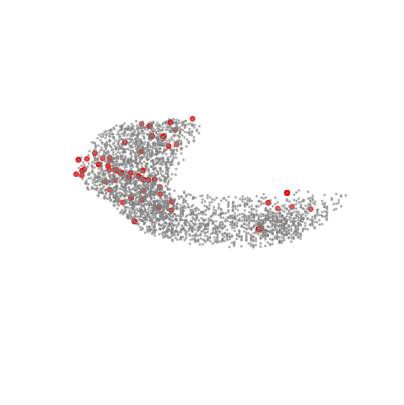

Processing test data:  25%|██▌       | 1/4 [00:00<00:01,  2.28it/s]

(57,)
Actual:  [1.3630719184875488, 'Predicted:', [[2.545689821243286]]]
Age: [43.62924425] 
 target: 1.3630719184875488 
 pred: [[2.545689821243286]]
 stage: ('2',)_('214181',)
critical_points/region4_1.svg


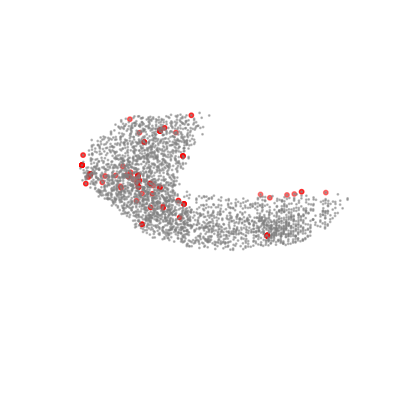

Processing test data:  50%|█████     | 2/4 [00:00<00:00,  2.30it/s]

(52,)
Actual:  [1.3630719184875488, 'Predicted:', [[2.111185073852539]]]
Age: [43.62924425] 
 target: 1.3630719184875488 
 pred: [[2.111185073852539]]
 stage: ('2',)_('214181',)
critical_points/region4_2.svg


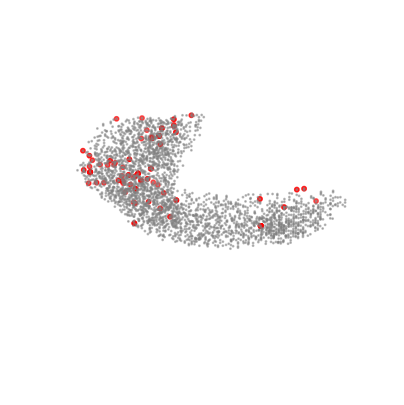

Processing test data:  75%|███████▌  | 3/4 [00:01<00:00,  2.32it/s]

(60,)
Actual:  [1.3630719184875488, 'Predicted:', [[2.1196444034576416]]]
Age: [43.62924425] 
 target: 1.3630719184875488 
 pred: [[2.1196444034576416]]
 stage: ('2',)_('214181',)
critical_points/region4_3.svg


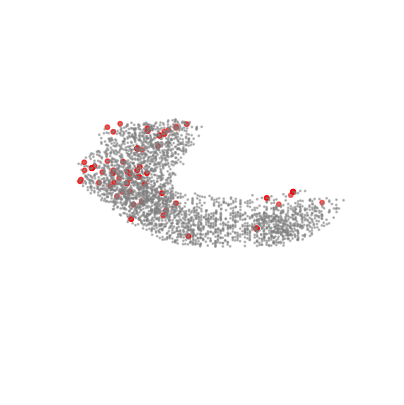

Processing test data: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

(57,)


In [20]:
REGION_LABEL = 4 # Name:Left-Lateral-Ventricle
save_dir = 'Region_' + str(REGION_LABEL) + '_models'

NUM_POINTS = 3000
GLOBAL_FEATS = 128

classifier = PointNetClassHead (num_points = NUM_POINTS , num_global_feats = GLOBAL_FEATS, k = NUM_CLASSES)
classifier = classifier.to(DEVICE)

### Load trained models
param_dict = torch.load(save_dir + '/cls_model_40_PIN.pth')
classifier.load_state_dict(param_dict)
classifier.eval();

global_features_array = []
critical_indexes_array = []
disease_stage_array = []
preds_array = []
targets_array = []

for i, (points, targets, stage , path , age , subjid) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points = points.to(DEVICE)
    targets = targets.squeeze().to(DEVICE)
    
    # Pass the points through the backbone of the PointNet
    global_features, critical_indexes , _ = classifier.backbone(points)
    preds, _ , _ = classifier(points)
       
    # Append the global features to the array
    preds_array.append(preds.cpu().data.numpy())
    targets_array.append(targets.cpu().data.numpy())
    global_features_array.append(global_features.cpu().data.numpy())
    critical_indexes_array.append(critical_indexes.cpu().data.numpy())
    disease_stage_array.append(stage)
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.axis('off')
    ax.scatter(points.squeeze()[0,critical_indexes], points.squeeze()[1, critical_indexes], points.squeeze()[2, critical_indexes] , s = 10 ,color = 'red', marker = 'o');
    ax.scatter(points.squeeze()[0,:], points.squeeze()[1,:], points.squeeze()[2,:], s=1 , color = 'gray' , alpha = .5, marker = 'o')
    print('Actual: ', [targets.detach().numpy().tolist() , 'Predicted:', preds.detach().numpy().tolist()])
    # Formatting the file name
    print(f"Age: {age.detach().numpy()} \n target: {targets.detach().numpy().tolist()} \n pred: {preds.detach().numpy().tolist()}\n stage: {stage}_{subjid}")
    file_name = f"critical_points/region{REGION_LABEL}_{i}.svg"
    print(file_name)
    # Saving the figure
    plt.savefig(file_name , format='svg')
    plt.show()
    print(np.unique(critical_indexes.numpy()).shape)
    np.savez('example/' +'region' + str(REGION_LABEL) +'.npz', points=points, preds_array=preds_array, targets_array=targets_array,
        global_features_array = global_features_array , critical_indexes_array=critical_indexes_array , 
         disease_stage_array=disease_stage_array)

## Region 11

Processing test data:   0%|          | 0/4 [00:00<?, ?it/s]

Actual:  [1.3630719184875488, 'Predicted:', [[2.467703342437744]]]
Age: [43.62924425] 
 target: 1.3630719184875488 
 pred: [[2.467703342437744]]
 stage: ('2',)_('214181',)
critical_points/region11_0.svg


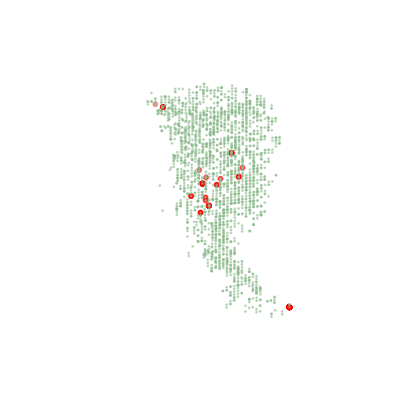

Processing test data:  25%|██▌       | 1/4 [00:00<00:00,  3.28it/s]

Actual:  [1.3630719184875488, 'Predicted:', [[2.3638644218444824]]]
Age: [43.62924425] 
 target: 1.3630719184875488 
 pred: [[2.3638644218444824]]
 stage: ('2',)_('214181',)
critical_points/region11_1.svg


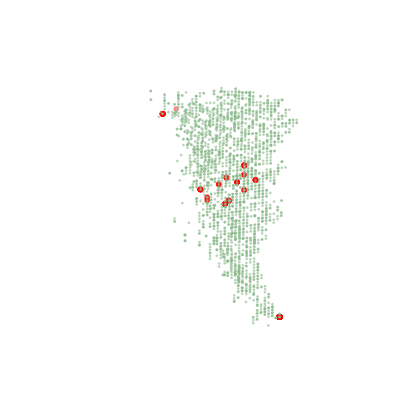

Processing test data:  50%|█████     | 2/4 [00:00<00:00,  3.42it/s]

Actual:  [1.3630719184875488, 'Predicted:', [[2.595867156982422]]]
Age: [43.62924425] 
 target: 1.3630719184875488 
 pred: [[2.595867156982422]]
 stage: ('2',)_('214181',)
critical_points/region11_2.svg


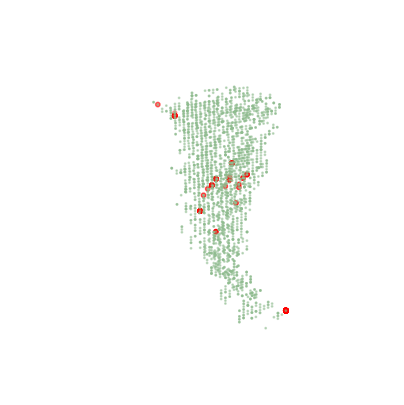

Processing test data:  75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

Actual:  [1.3630719184875488, 'Predicted:', [[2.291309118270874]]]
Age: [43.62924425] 
 target: 1.3630719184875488 
 pred: [[2.291309118270874]]
 stage: ('2',)_('214181',)
critical_points/region11_3.svg


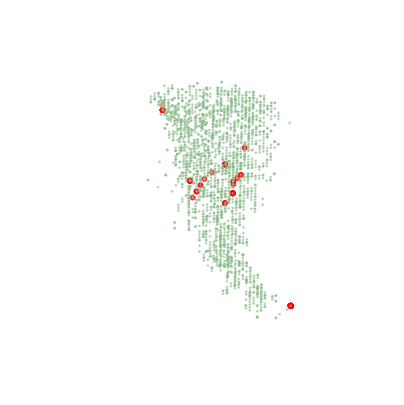

Processing test data: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


In [17]:
REGION_LABEL = 11 # Name:Left-Caudate
save_dir = 'Region_' + str(REGION_LABEL) + '_models'

NUM_POINTS = 2400
GLOBAL_FEATS = 128

classifier = PointNetClassHead (num_points = NUM_POINTS , num_global_feats = GLOBAL_FEATS, k = NUM_CLASSES)
classifier = classifier.to(DEVICE)

### Load trained models
param_dict = torch.load(save_dir + '/cls_model_50_PIN.pth')
classifier.load_state_dict(param_dict)
classifier.eval();

global_features_array = []
critical_indexes_array = []
disease_stage_array = []
preds_array = []
targets_array = []

for i, (points, targets, stage , path , age , subjid) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points = points.to(DEVICE)
    targets = targets.squeeze().to(DEVICE)
    
    # Pass the points through the backbone of the PointNet
    global_features, critical_indexes , _ = classifier.backbone(points)
    preds, _ , _ = classifier(points)
       
    # Append the global features to the array
    preds_array.append(preds.cpu().data.numpy())
    targets_array.append(targets.cpu().data.numpy())
    global_features_array.append(global_features.cpu().data.numpy())
    critical_indexes_array.append(critical_indexes.cpu().data.numpy())
    disease_stage_array.append(stage)
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.axis('off')
    ax.scatter(points.squeeze()[0,critical_indexes], points.squeeze()[1, critical_indexes], points.squeeze()[2, critical_indexes] , s = 10 ,color = 'red', marker = 'o');
    ax.scatter(points.squeeze()[0,:], points.squeeze()[1,:], points.squeeze()[2,:], s=1 , color = 'darkseagreen' , alpha = .5, marker = 'o')
    print('Actual: ', [targets.detach().numpy().tolist() , 'Predicted:', preds.detach().numpy().tolist()])
    # Formatting the file name
    print(f"Age: {age.detach().numpy()} \n target: {targets.detach().numpy().tolist()} \n pred: {preds.detach().numpy().tolist()}\n stage: {stage}_{subjid}")
    file_name = f"critical_points/region{REGION_LABEL}_{i}.svg"
    print(file_name)
    # Saving the figure
    plt.savefig(file_name , format='svg')
    plt.show()
    np.savez('example/' +'region' + str(REGION_LABEL) +'.npz', points=points, preds_array=preds_array, targets_array=targets_array,
        global_features_array = global_features_array , critical_indexes_array=critical_indexes_array , 
         disease_stage_array=disease_stage_array)

## Region 12

Processing test data:   0%|          | 0/4 [00:00<?, ?it/s]

Actual:  [1.3630719184875488, 'Predicted:', [[2.1875460147857666]]]
Age: [43.62924425] 
 target: 1.3630719184875488 
 pred: [[2.1875460147857666]]
 stage: ('2',)_('214181',)
critical_points/region12_0.svg


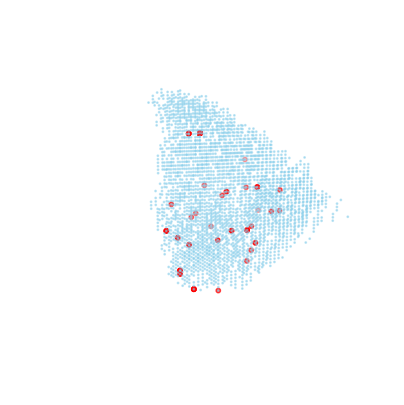

Processing test data:  25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

Actual:  [1.3630719184875488, 'Predicted:', [[1.6259024143218994]]]
Age: [43.62924425] 
 target: 1.3630719184875488 
 pred: [[1.6259024143218994]]
 stage: ('2',)_('214181',)
critical_points/region12_1.svg


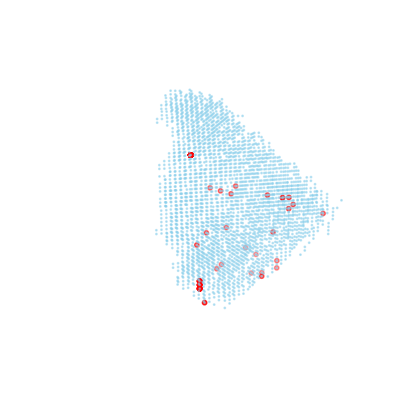

Processing test data:  50%|█████     | 2/4 [00:00<00:00,  3.43it/s]

Actual:  [1.3630719184875488, 'Predicted:', [[2.2207067012786865]]]
Age: [43.62924425] 
 target: 1.3630719184875488 
 pred: [[2.2207067012786865]]
 stage: ('2',)_('214181',)
critical_points/region12_2.svg


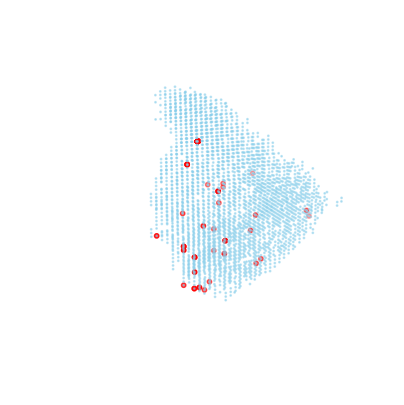

Processing test data:  75%|███████▌  | 3/4 [00:00<00:00,  3.34it/s]

Actual:  [1.3630719184875488, 'Predicted:', [[1.6972248554229736]]]
Age: [43.62924425] 
 target: 1.3630719184875488 
 pred: [[1.6972248554229736]]
 stage: ('2',)_('214181',)
critical_points/region12_3.svg


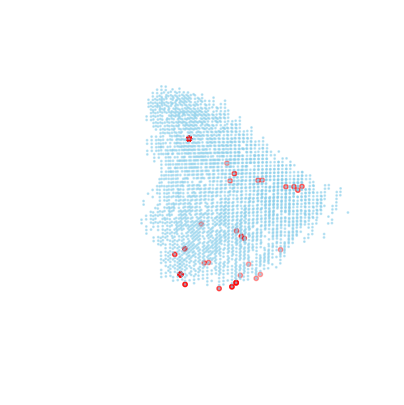

Processing test data: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


In [19]:
REGION_LABEL = 12 # Name:Left-Putamen
save_dir = 'Region_' + str(REGION_LABEL) + '_models'

NUM_POINTS = 3000
GLOBAL_FEATS = 128

classifier = PointNetClassHead (num_points = NUM_POINTS , num_global_feats = GLOBAL_FEATS, k = NUM_CLASSES)
classifier = classifier.to(DEVICE)

### Load trained models
param_dict = torch.load(save_dir + '/cls_model_48_PIN.pth')
classifier.load_state_dict(param_dict)
classifier.eval();

global_features_array = []
critical_indexes_array = []
disease_stage_array = []
preds_array = []
targets_array = []

for i, (points, targets, stage , path , age , subjid) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points = points.to(DEVICE)
    targets = targets.squeeze().to(DEVICE)
    
    # Pass the points through the backbone of the PointNet
    global_features, critical_indexes , _ = classifier.backbone(points)
    preds, _ , _ = classifier(points)
       
    # Append the global features to the array
    preds_array.append(preds.cpu().data.numpy())
    targets_array.append(targets.cpu().data.numpy())
    global_features_array.append(global_features.cpu().data.numpy())
    critical_indexes_array.append(critical_indexes.cpu().data.numpy())
    disease_stage_array.append(stage)
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.axis('off')
    ax.scatter(points.squeeze()[0,critical_indexes], points.squeeze()[1, critical_indexes], points.squeeze()[2, critical_indexes] , s = 10 ,color = 'red', marker = 'o');
    ax.scatter(points.squeeze()[0,:], points.squeeze()[1,:], points.squeeze()[2,:], s=1 , color = 'skyblue' , alpha = .5, marker = 'o')
    print('Actual: ', [targets.detach().numpy().tolist() , 'Predicted:', preds.detach().numpy().tolist()])
    # Formatting the file name
    print(f"Age: {age.detach().numpy()} \n target: {targets.detach().numpy().tolist()} \n pred: {preds.detach().numpy().tolist()}\n stage: {stage}_{subjid}")
    file_name = f"critical_points/region{REGION_LABEL}_{i}.svg"
    print(file_name)
    # Saving the figure
    plt.savefig(file_name , format='svg')
    plt.show()
    np.savez('example/' +'region' + str(REGION_LABEL) +'.npz', points=points, preds_array=preds_array, targets_array=targets_array,
        global_features_array = global_features_array , critical_indexes_array=critical_indexes_array , 
         disease_stage_array=disease_stage_array)

## Load saved example

In [21]:
data = np.load('example/' + 'region' + str(4) + '.npz')

In [23]:
preds_array = data['preds_array'].squeeze()
print(preds_array)

[2.1952434 2.5456898 2.111185  2.1196444]
